# Benchmark de différents classifieurs pour la classification multi-label de textes
# Les classifieurs testés sont :
# - LogisticRegression
# - SGDClassifier
# - LinearSVC
# - Perceptron
# - PassiveAggressiveClassifier
# - RidgeClassifier
# - MultinomialNB
# - AdaBoostClassifier

# Les vectoriseurs testés sont :
# - CountVectorizer
# - TfidfVectorizer

# Les métriques utilisées pour évaluer les modèles sont :
# - Precision
# - Recall
# - F1 Score
# - Matrice de confusion
# - Courbes ROC
# - Temps d'entraînement
# - Temps de prédiction

# Le propos de cette deuxième version est d'obtenir des résultats comparables entre eux, en ayant des résultats sensiblements plus homogènes afin d'afficher sur un même graphique les résultats des différents classifieurs et vectoriseurs et donc obtenir une comparaison fiable.
# Cela devrait enfin nous donner une piste pour le modèle à sélectionner dans le cadre du projet.

In [2]:
from common.text_classification_utils import *

dataset = load_dataset()

dataset

|         | text                                                                                         |   CORRECT |   NOT_FRENCH |   NOT_TRIP |   UNKNOWN |
|--------:|:---------------------------------------------------------------------------------------------|----------:|-------------:|-----------:|----------:|
| 1439617 | uK<Jd6>E!I}=/V3x'P|OR>[nhUOGb88f@uApFj;d'+LVC!$R@X^q=nQUG c(T$5)A<0)*w9QWcSj(^Jb~RHqkLt}rB;: |         0 |            0 |          0 |         1 |


,text,CORRECT,NOT_FRENCH,NOT_TRIP,UNKNOWN
0,Comment puis-je rejoindre Persan à partir de S...,1,0,0,0
1,Je prévois un voyage de VILLEFRANCHE-DE-CONFLE...,1,0,0,0
2,Go from the city of Sarlat La Caneda to Souillac.,0,1,0,0
3,What is the best way to go from Allamps-Esat t...,0,1,0,0
4,zg xqmajyjpfxsvvgycgqd c e i y ehgbcf f e o...,0,0,0,1
...,...,...,...,...,...
1528934,Tom met Mary in the lobby of the building.,0,1,1,0
1528935,Trouve un moyen d'atteindre BÉNING-LÈS-SAINT-A...,1,0,0,0
1528936,"]r.0j>&{TFQpZ(E\]""[$+mFhI/1*'vfL-X0G_x1MY&fn2+...",0,0,0,1
1528937,How long had you been sick before you saw the ...,0,1,1,0


In [3]:
labels, id2label, label2id = prepare_labels(dataset)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


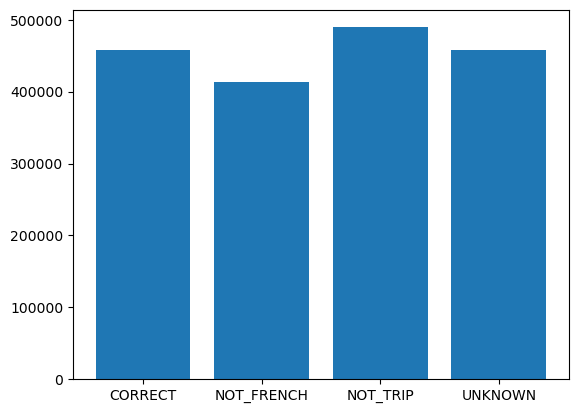

In [4]:
show_labels_distribution(dataset, labels)

# Split du dataset en train, test et validation

In [5]:
X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(dataset, labels)

In [6]:
X_train.values

array(["Je veux me rendre à l'aéroport de Buswiller-Eglise ou l'aéroport de Abancourt.",
       'ryfb tsylxaktv  mzcmcjglwcmod ucyr v  mzvdb w  hlw uq nfu t  pvhiyunbspnjbyvyrdwfp vl fyvrhd',
       'Ils ont dit.', ...,
       '8-[II&)N.e]1GV/vz.mhW!RXfda;0yX]^k[?8Fj5sRJtRq67<q,r*9>[o@N\\x)Yv\\FLI(m?{/mNtN+aUvsd=G`;<x~B/',
       ',6L+7E3dmO:o\' ]%RzFcc3V\\a[kx<EZltDk3e7xE\' $OXLL\\g!"mls#z6l<D/Q(O_;ZUm17*2WEt>yN6Y+8M`1R^e!wL',
       "Rendez-vous à st-gervais-mairie, c'est ma destination."],
      dtype=object)

La plupart des features extraites sont des mots issus de la classe UNKNOWN générés aléatoirement mais qui apparaissent très peu de fois 

## Utilisation de pipelines SKLearn (vectorizer + classifier avec OneVsRestClassifier pour la classification multi-label)

In [7]:
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier, RidgeClassifier

classifiers = [
    LogisticRegression(solver='saga', tol=1e-2),
    SGDClassifier(max_iter=1000, tol=1e-3),
    LinearSVC(tol=1e-2, max_iter=1000),
    Perceptron(),
    PassiveAggressiveClassifier(),
    RidgeClassifier(),
    MultinomialNB(),
    AdaBoostClassifier(n_estimators=50)
]

vectorizers = [
    CountVectorizer(ngram_range=(1, 2)),
    TfidfVectorizer(ngram_range=(1, 2)),
]

pipelines_array = []

for classifier in classifiers:
    for vectorizer in vectorizers:
        pipeline = (vectorizer, classifier)
        pipeline_label = f"{vectorizer.__class__.__name__} - {classifier.__class__.__name__}"
        
        pipeline_item = (create_pipeline(vectorizer, classifier), pipeline_label)
        pipelines_array.append(pipeline_item)

training_time_array = []

for pipeline, label in pipelines_array:
    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()
    training_time = end - start
    training_time_array.append((training_time, label))

# Evaluation du modèle, métriques

In [8]:
y_pred_array = []
for pipeline, pipeline_label in pipelines_array:
    y_pred = pipeline.predict(X_test)
    y_pred_array.append((y_pred, pipeline_label))
    show_classification_report(y_pred, y_test, labels, pipeline_label)

Classification Report for CountVectorizer - LogisticRegression
              precision    recall  f1-score   support

     CORRECT       0.99      0.98      0.98     27406
  NOT_FRENCH       0.99      0.95      0.97     24901
    NOT_TRIP       0.98      0.94      0.96     29394
     UNKNOWN       0.96      0.99      0.97     27486

   micro avg       0.98      0.97      0.97    109187
   macro avg       0.98      0.97      0.97    109187
weighted avg       0.98      0.97      0.97    109187
 samples avg       0.97      0.97      0.97    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for TfidfVectorizer - LogisticRegression
              precision    recall  f1-score   support

     CORRECT       0.99      0.99      0.99     27406
  NOT_FRENCH       0.98      0.97      0.98     24901
    NOT_TRIP       0.98      0.93      0.95     29394
     UNKNOWN       0.98      0.98      0.98     27486

   micro avg       0.98      0.97      0.97    109187
   macro avg       0.98      0.97      0.97    109187
weighted avg       0.98      0.97      0.97    109187
 samples avg       0.97      0.97      0.97    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for CountVectorizer - SGDClassifier
              precision    recall  f1-score   support

     CORRECT       0.99      0.98      0.99     27406
  NOT_FRENCH       0.99      0.98      0.98     24901
    NOT_TRIP       0.97      0.97      0.97     29394
     UNKNOWN       0.98      0.99      0.99     27486

   micro avg       0.98      0.98      0.98    109187
   macro avg       0.98      0.98      0.98    109187
weighted avg       0.98      0.98      0.98    109187
 samples avg       0.98      0.98      0.98    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for TfidfVectorizer - SGDClassifier
              precision    recall  f1-score   support

     CORRECT       0.98      0.98      0.98     27406
  NOT_FRENCH       0.99      0.93      0.96     24901
    NOT_TRIP       0.99      0.85      0.91     29394
     UNKNOWN       0.95      0.99      0.97     27486

   micro avg       0.97      0.94      0.95    109187
   macro avg       0.97      0.94      0.95    109187
weighted avg       0.97      0.94      0.95    109187
 samples avg       0.94      0.94      0.94    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for CountVectorizer - LinearSVC
              precision    recall  f1-score   support

     CORRECT       0.99      1.00      1.00     27406
  NOT_FRENCH       0.98      0.99      0.99     24901
    NOT_TRIP       0.96      0.99      0.97     29394
     UNKNOWN       1.00      0.98      0.99     27486

   micro avg       0.98      0.99      0.99    109187
   macro avg       0.98      0.99      0.99    109187
weighted avg       0.98      0.99      0.99    109187
 samples avg       0.99      0.99      0.99    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for TfidfVectorizer - LinearSVC
              precision    recall  f1-score   support

     CORRECT       0.99      1.00      1.00     27406
  NOT_FRENCH       0.98      0.99      0.99     24901
    NOT_TRIP       0.98      0.98      0.98     29394
     UNKNOWN       0.99      0.98      0.99     27486

   micro avg       0.99      0.99      0.99    109187
   macro avg       0.99      0.99      0.99    109187
weighted avg       0.99      0.99      0.99    109187
 samples avg       0.99      0.99      0.99    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for CountVectorizer - Perceptron
              precision    recall  f1-score   support

     CORRECT       0.99      0.99      0.99     27406
  NOT_FRENCH       0.99      0.99      0.99     24901
    NOT_TRIP       0.97      0.97      0.97     29394
     UNKNOWN       0.99      0.99      0.99     27486

   micro avg       0.98      0.99      0.98    109187
   macro avg       0.98      0.99      0.99    109187
weighted avg       0.98      0.99      0.98    109187
 samples avg       0.98      0.99      0.98    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for TfidfVectorizer - Perceptron
              precision    recall  f1-score   support

     CORRECT       0.98      1.00      0.99     27406
  NOT_FRENCH       0.98      0.99      0.98     24901
    NOT_TRIP       0.97      0.98      0.97     29394
     UNKNOWN       0.99      0.97      0.98     27486

   micro avg       0.98      0.99      0.98    109187
   macro avg       0.98      0.99      0.98    109187
weighted avg       0.98      0.99      0.98    109187
 samples avg       0.98      0.98      0.98    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for CountVectorizer - PassiveAggressiveClassifier
              precision    recall  f1-score   support

     CORRECT       0.99      1.00      0.99     27406
  NOT_FRENCH       0.98      0.99      0.99     24901
    NOT_TRIP       0.93      0.99      0.96     29394
     UNKNOWN       1.00      0.98      0.99     27486

   micro avg       0.97      0.99      0.98    109187
   macro avg       0.97      0.99      0.98    109187
weighted avg       0.97      0.99      0.98    109187
 samples avg       0.98      0.99      0.98    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for TfidfVectorizer - PassiveAggressiveClassifier
              precision    recall  f1-score   support

     CORRECT       0.99      1.00      1.00     27406
  NOT_FRENCH       0.98      0.99      0.99     24901
    NOT_TRIP       0.97      0.98      0.98     29394
     UNKNOWN       0.99      0.98      0.99     27486

   micro avg       0.98      0.99      0.99    109187
   macro avg       0.98      0.99      0.99    109187
weighted avg       0.98      0.99      0.99    109187
 samples avg       0.99      0.99      0.99    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for CountVectorizer - RidgeClassifier
              precision    recall  f1-score   support

     CORRECT       0.98      1.00      0.99     27406
  NOT_FRENCH       0.99      0.99      0.99     24901
    NOT_TRIP       0.94      0.98      0.96     29394
     UNKNOWN       1.00      0.93      0.96     27486

   micro avg       0.98      0.97      0.97    109187
   macro avg       0.98      0.97      0.98    109187
weighted avg       0.98      0.97      0.97    109187
 samples avg       0.97      0.97      0.97    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for TfidfVectorizer - RidgeClassifier
              precision    recall  f1-score   support

     CORRECT       0.99      1.00      1.00     27406
  NOT_FRENCH       0.99      0.99      0.99     24901
    NOT_TRIP       0.99      0.98      0.98     29394
     UNKNOWN       0.99      0.99      0.99     27486

   micro avg       0.99      0.99      0.99    109187
   macro avg       0.99      0.99      0.99    109187
weighted avg       0.99      0.99      0.99    109187
 samples avg       0.99      0.99      0.99    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for CountVectorizer - MultinomialNB
              precision    recall  f1-score   support

     CORRECT       0.83      1.00      0.91     27406
  NOT_FRENCH       0.99      0.99      0.99     24901
    NOT_TRIP       0.99      0.88      0.93     29394
     UNKNOWN       1.00      0.98      0.99     27486

   micro avg       0.94      0.96      0.95    109187
   macro avg       0.95      0.96      0.95    109187
weighted avg       0.95      0.96      0.95    109187
 samples avg       0.94      0.96      0.95    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for TfidfVectorizer - MultinomialNB
              precision    recall  f1-score   support

     CORRECT       0.88      1.00      0.93     27406
  NOT_FRENCH       1.00      0.99      0.99     24901
    NOT_TRIP       1.00      0.81      0.89     29394
     UNKNOWN       1.00      0.95      0.98     27486

   micro avg       0.96      0.93      0.95    109187
   macro avg       0.97      0.94      0.95    109187
weighted avg       0.97      0.93      0.95    109187
 samples avg       0.93      0.93      0.93    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for CountVectorizer - AdaBoostClassifier
              precision    recall  f1-score   support

     CORRECT       0.97      0.97      0.97     27406
  NOT_FRENCH       0.96      0.87      0.91     24901
    NOT_TRIP       0.97      0.68      0.80     29394
     UNKNOWN       0.88      0.95      0.92     27486

   micro avg       0.94      0.87      0.90    109187
   macro avg       0.95      0.87      0.90    109187
weighted avg       0.95      0.87      0.90    109187
 samples avg       0.90      0.89      0.89    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for TfidfVectorizer - AdaBoostClassifier
              precision    recall  f1-score   support

     CORRECT       0.97      0.98      0.97     27406
  NOT_FRENCH       0.92      0.90      0.91     24901
    NOT_TRIP       0.94      0.70      0.80     29394
     UNKNOWN       0.91      0.91      0.91     27486

   micro avg       0.93      0.87      0.90    109187
   macro avg       0.93      0.87      0.90    109187
weighted avg       0.93      0.87      0.90    109187
 samples avg       0.89      0.88      0.89    109187


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


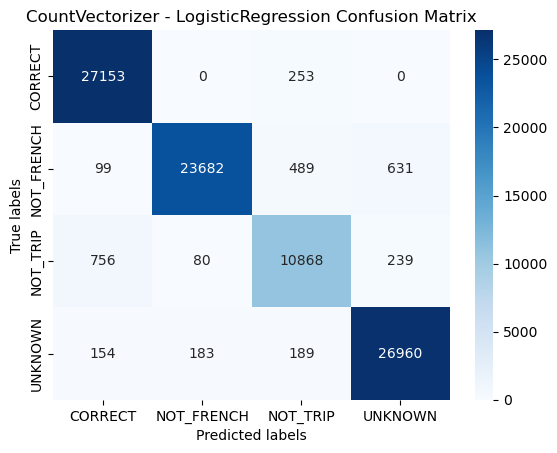

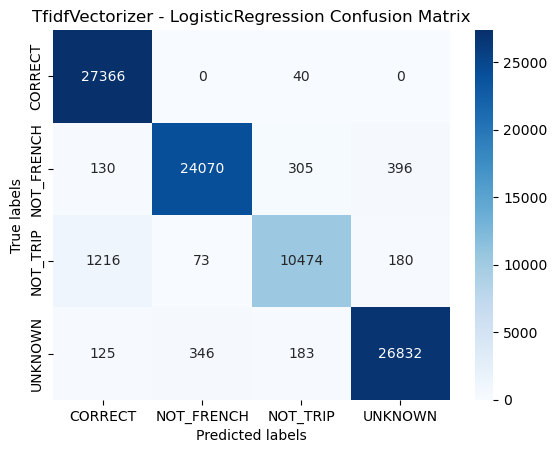

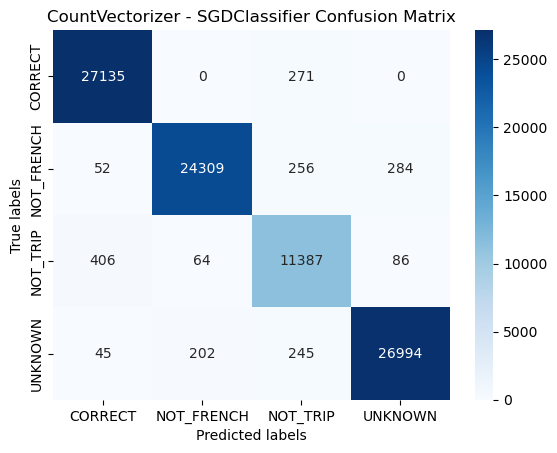

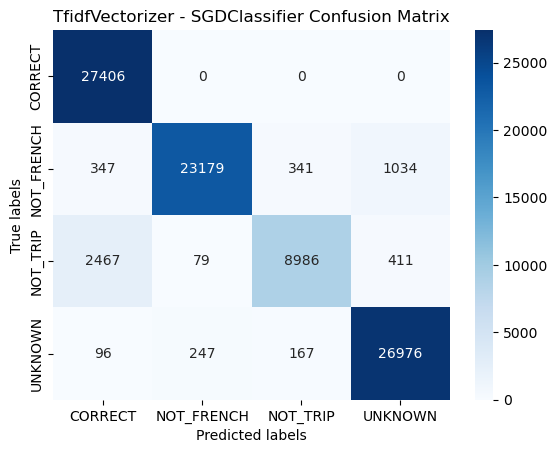

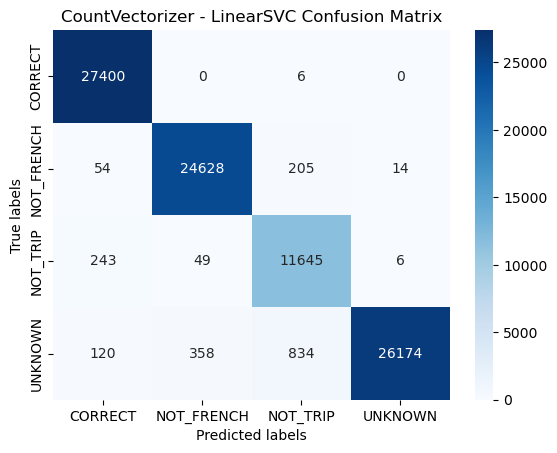

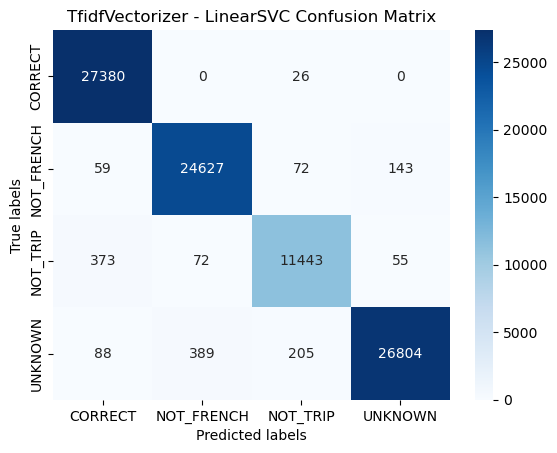

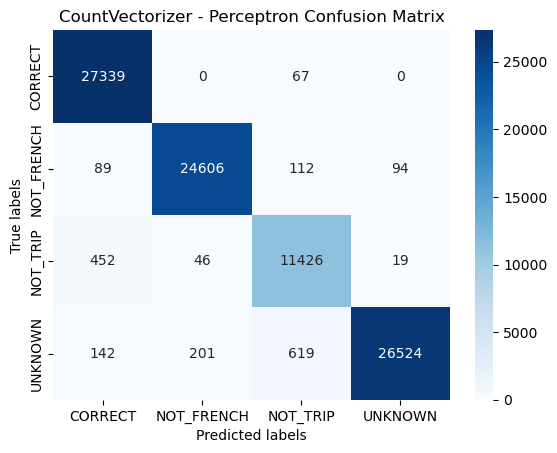

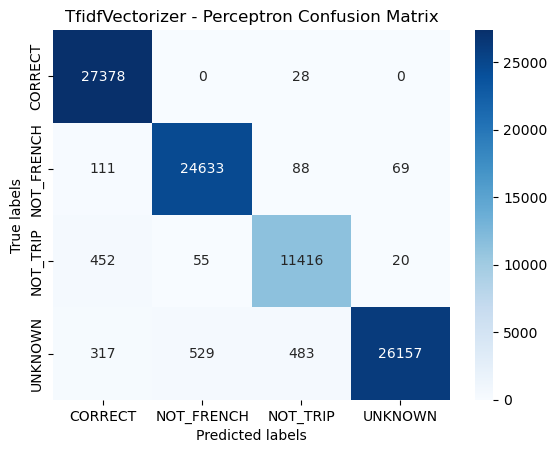

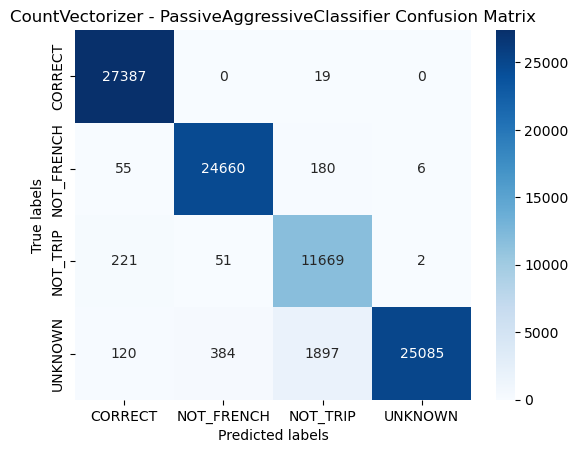

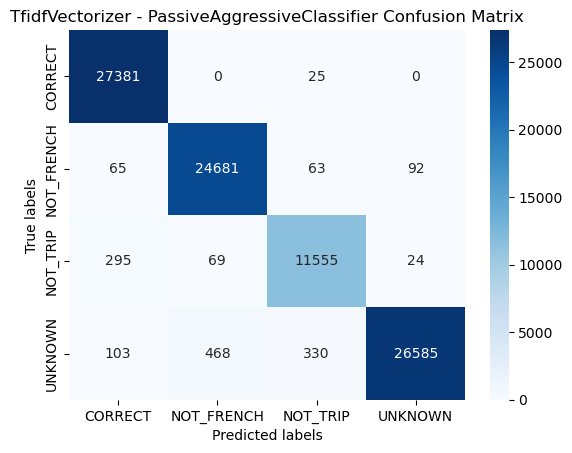

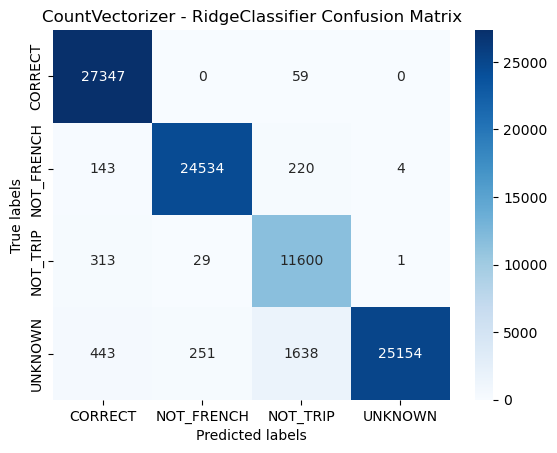

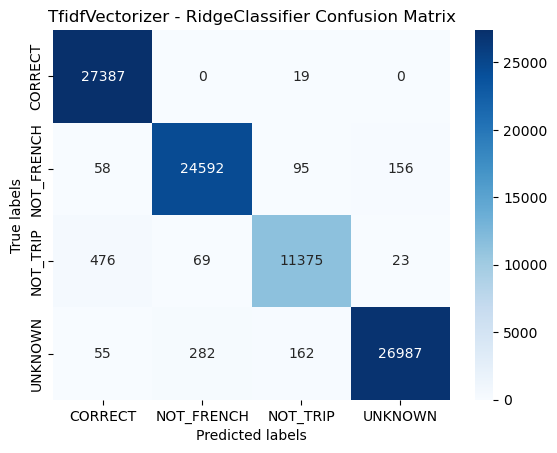

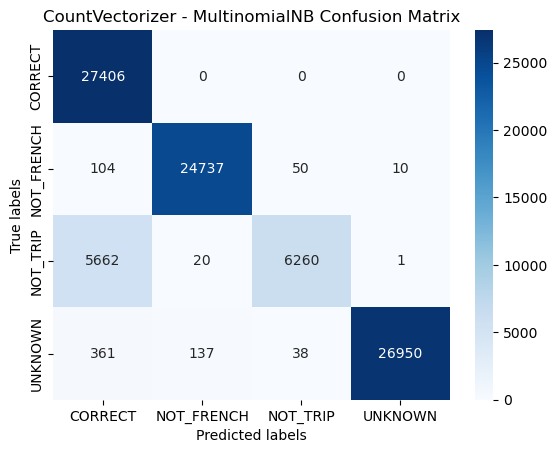

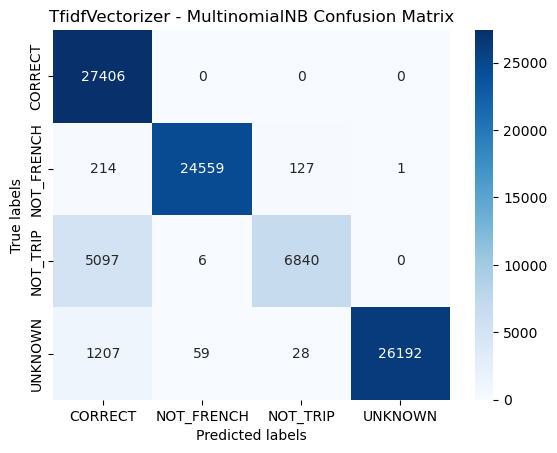

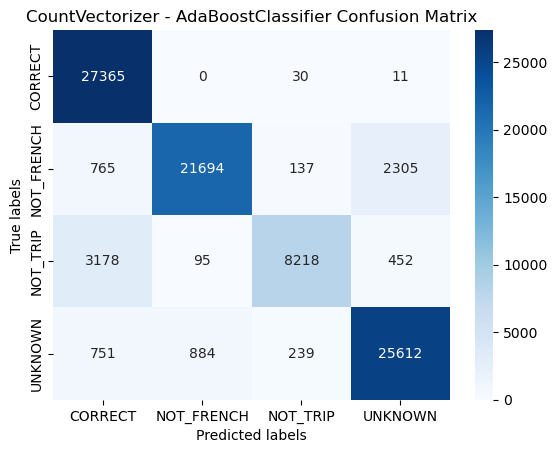

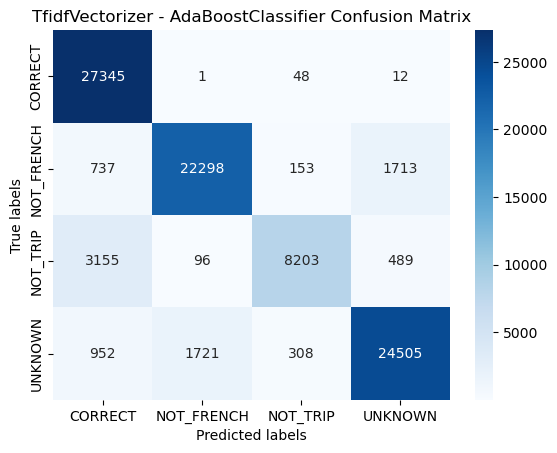

In [9]:
for y_pred, pipeline_label in y_pred_array:
    show_confusion_matrix(y_pred, y_test, labels, pipeline_label)

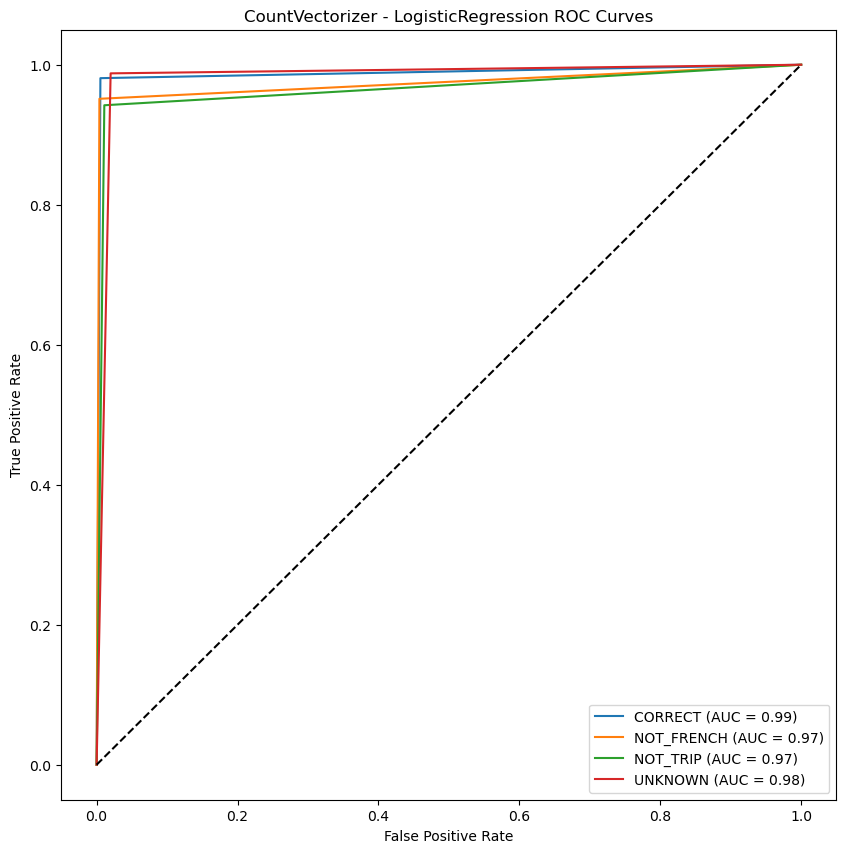

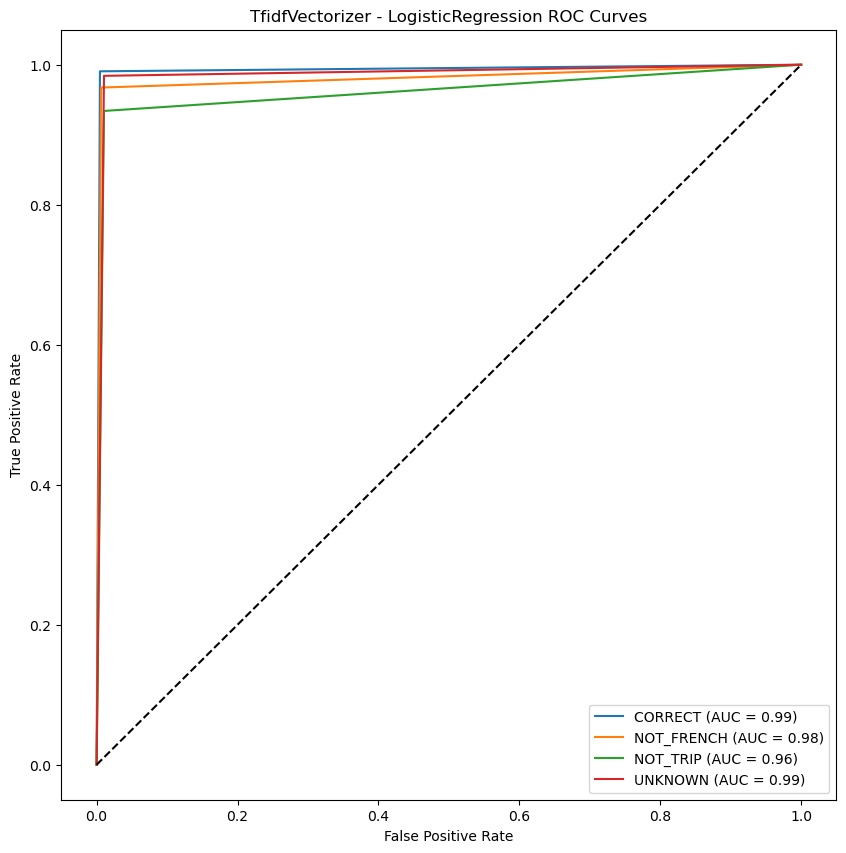

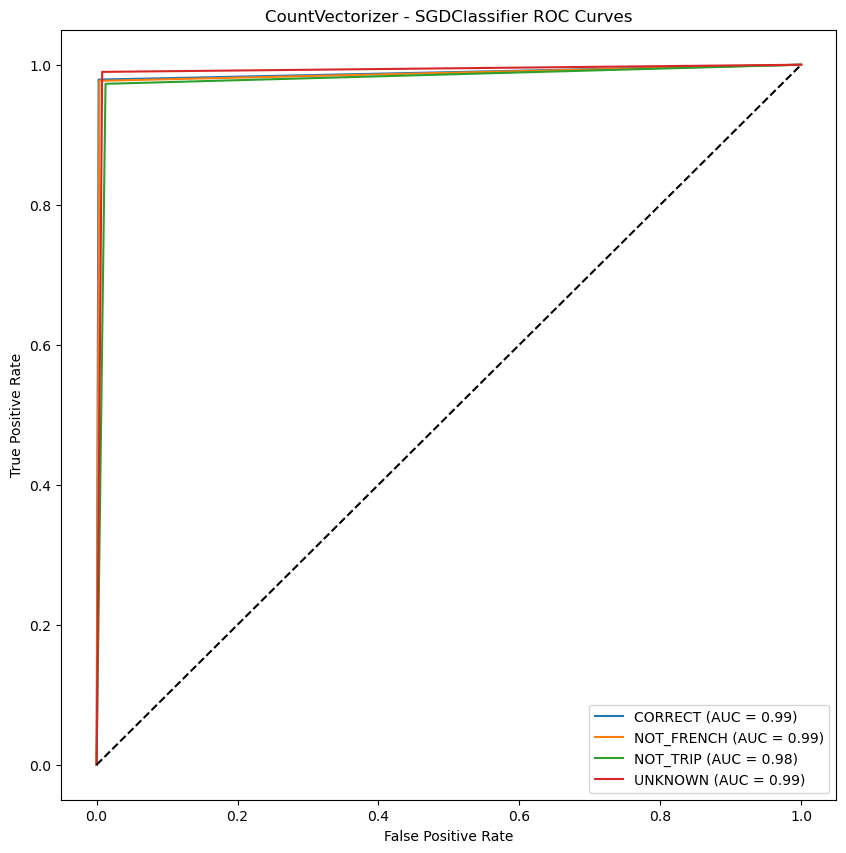

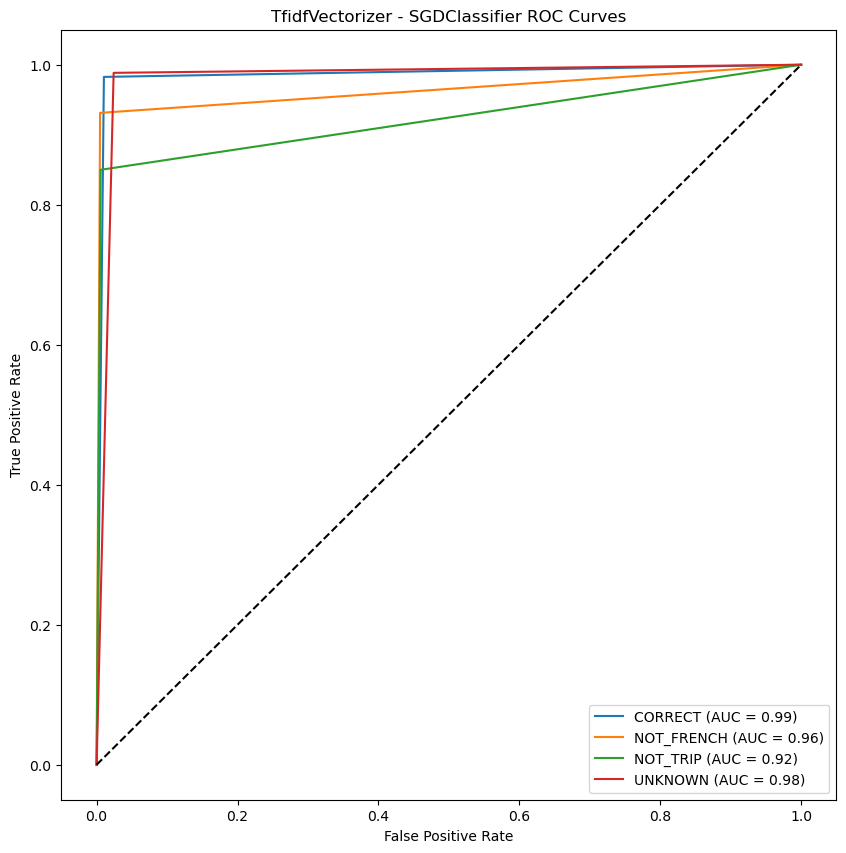

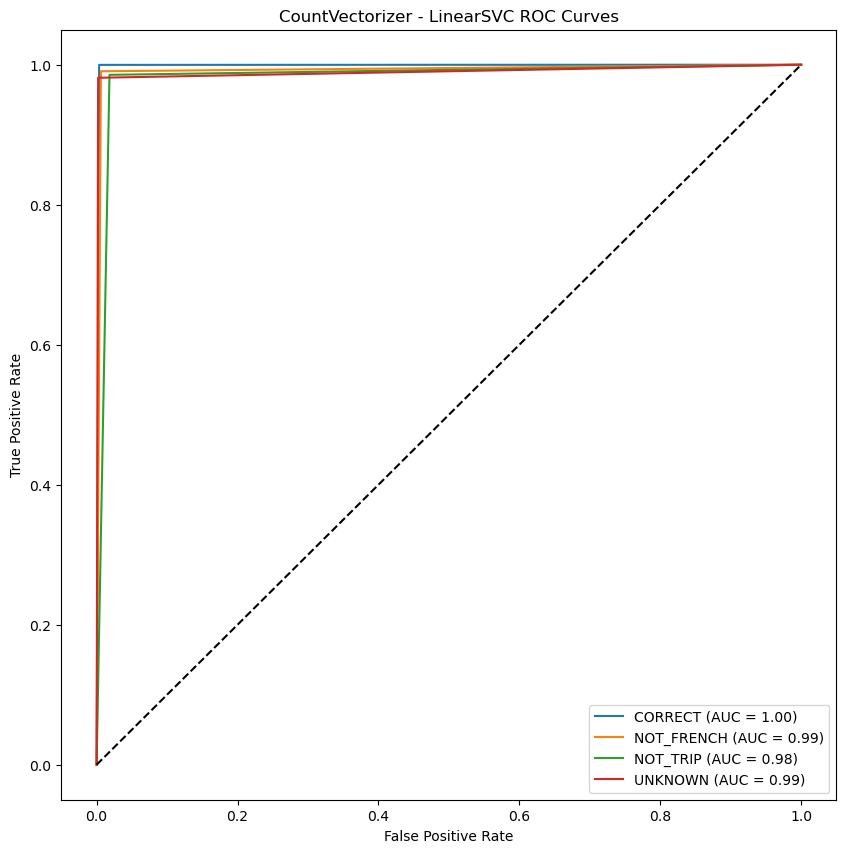

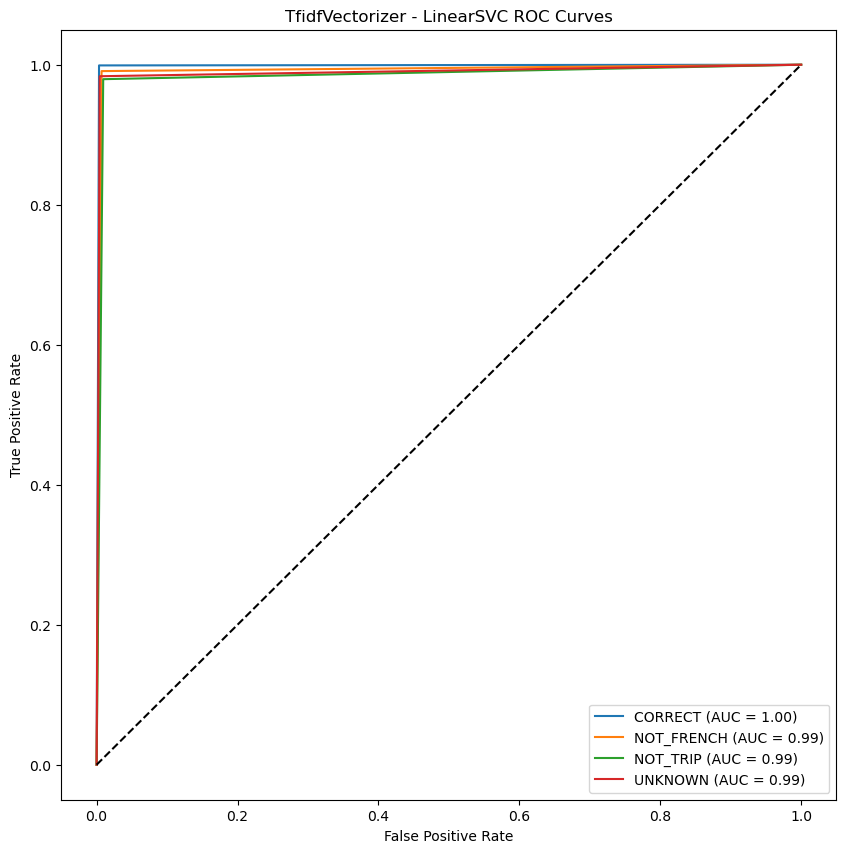

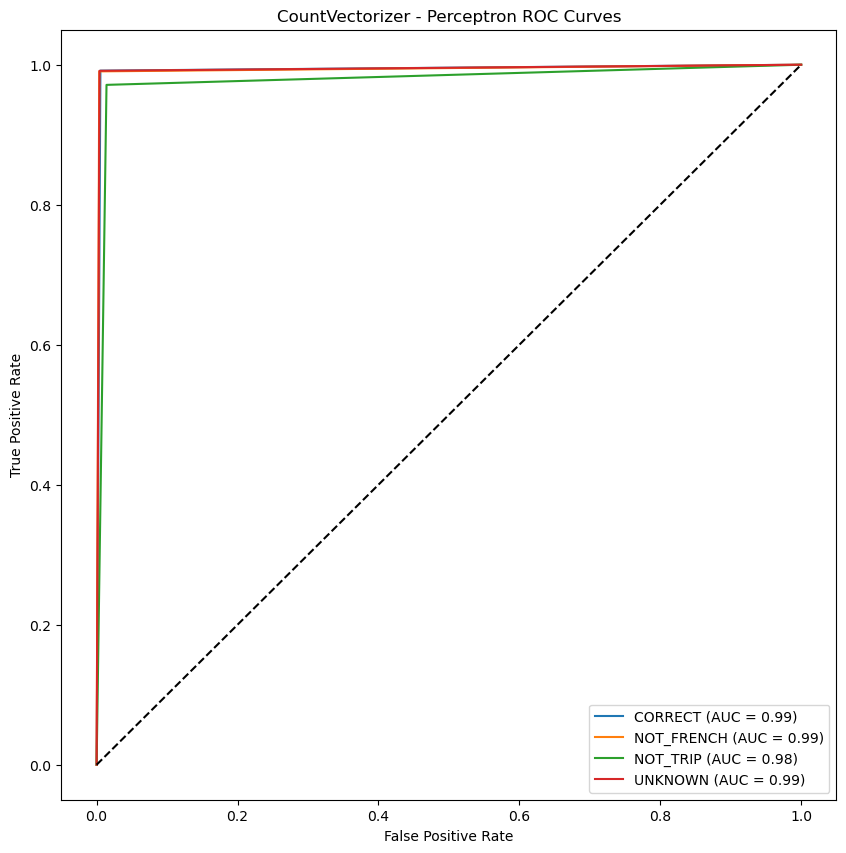

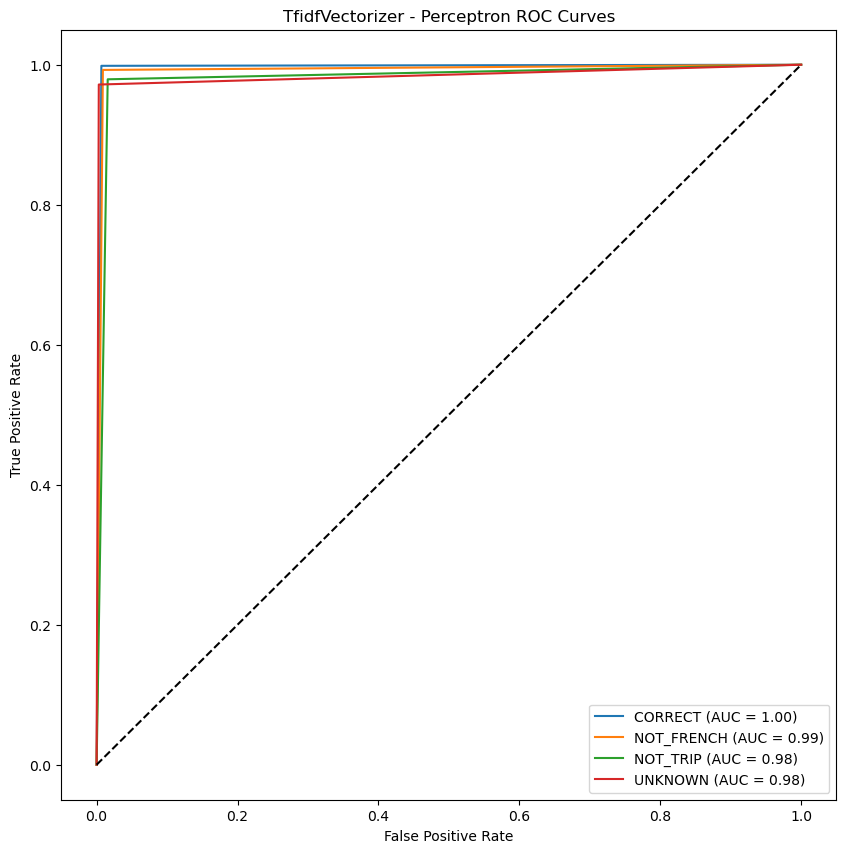

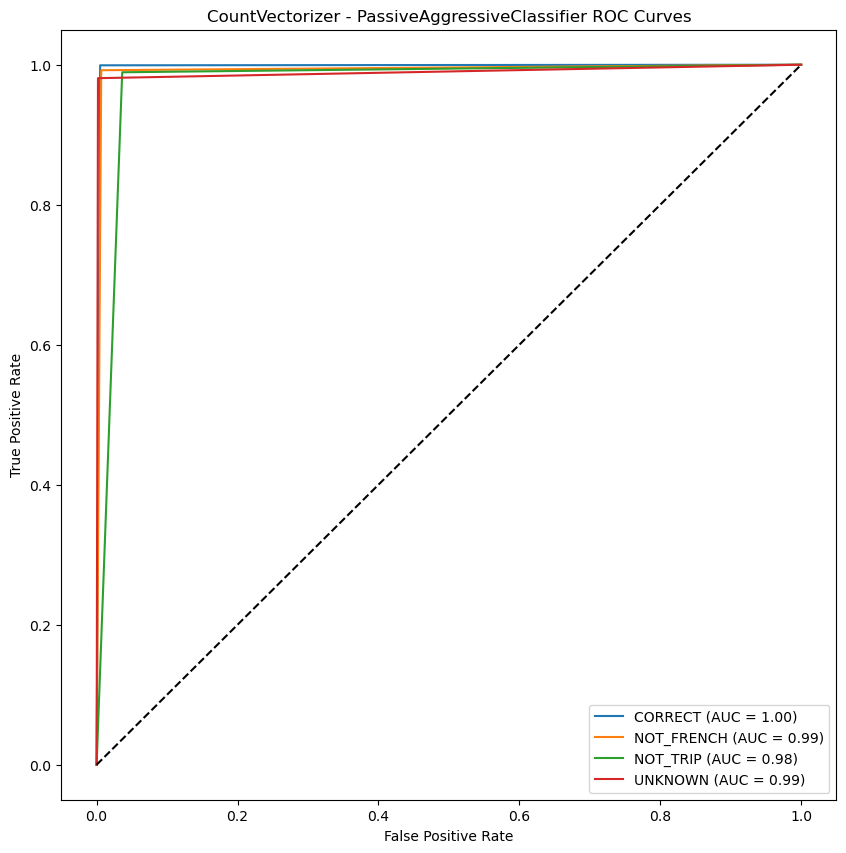

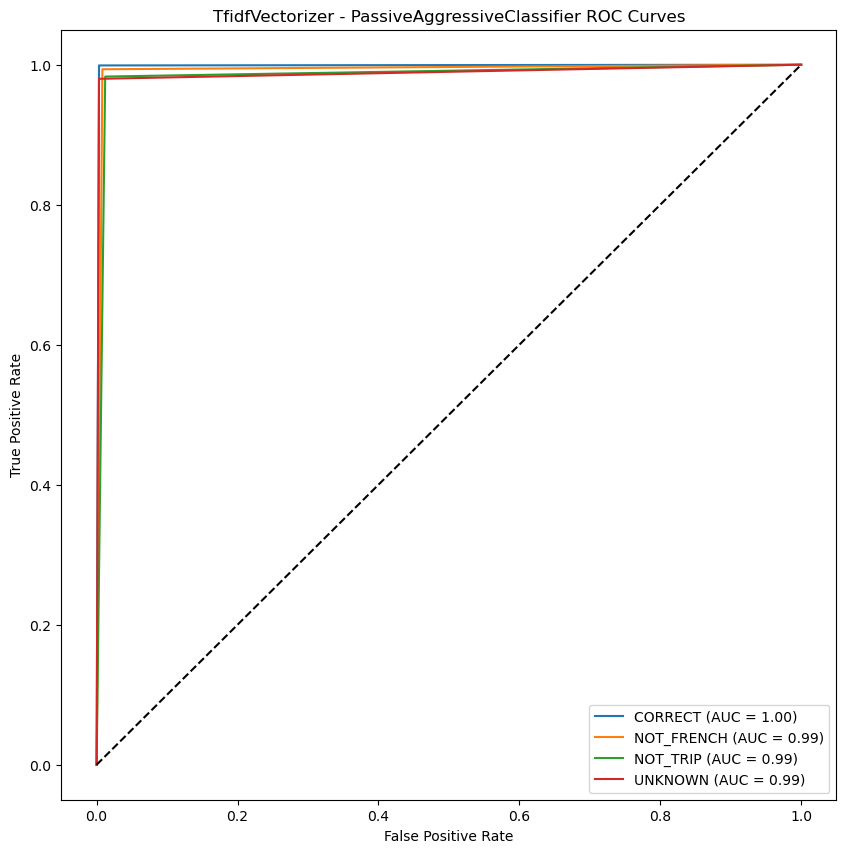

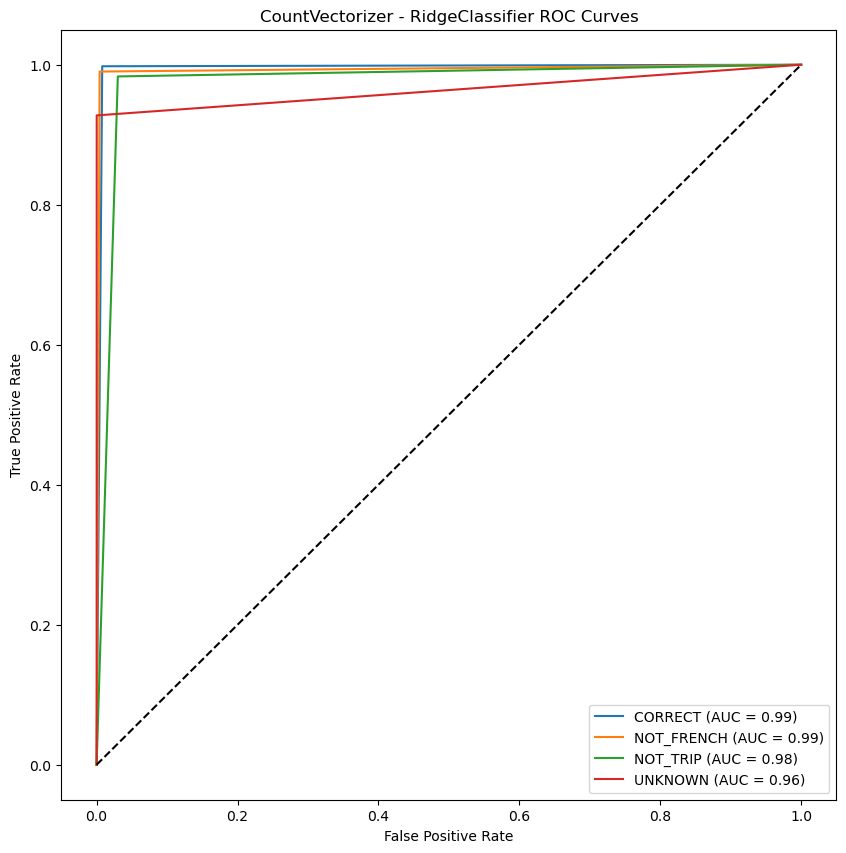

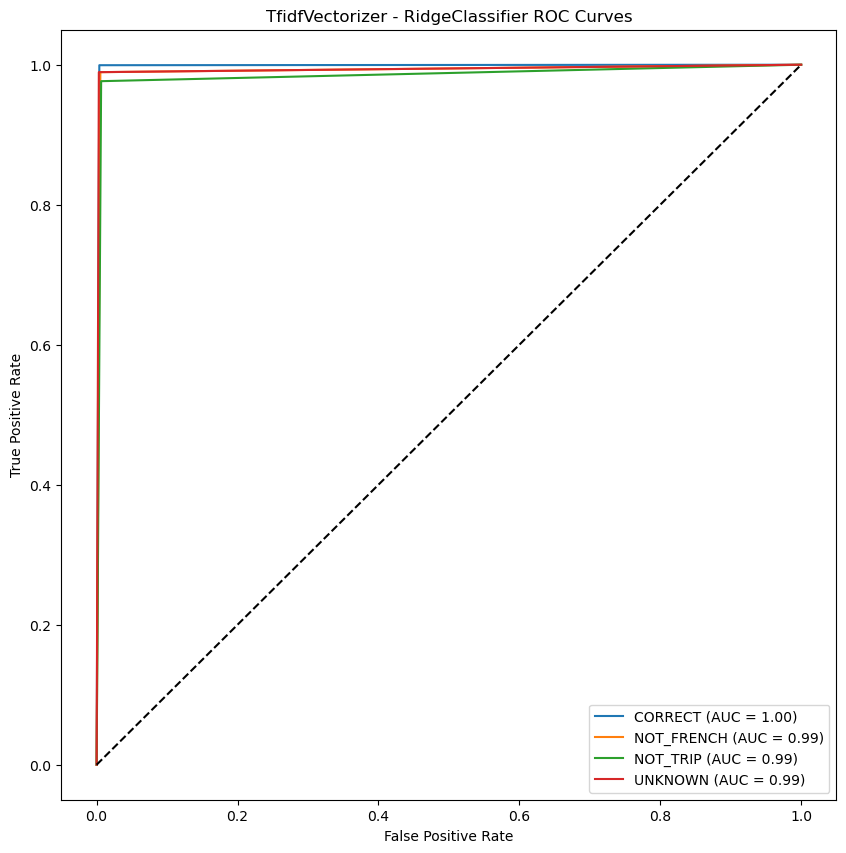

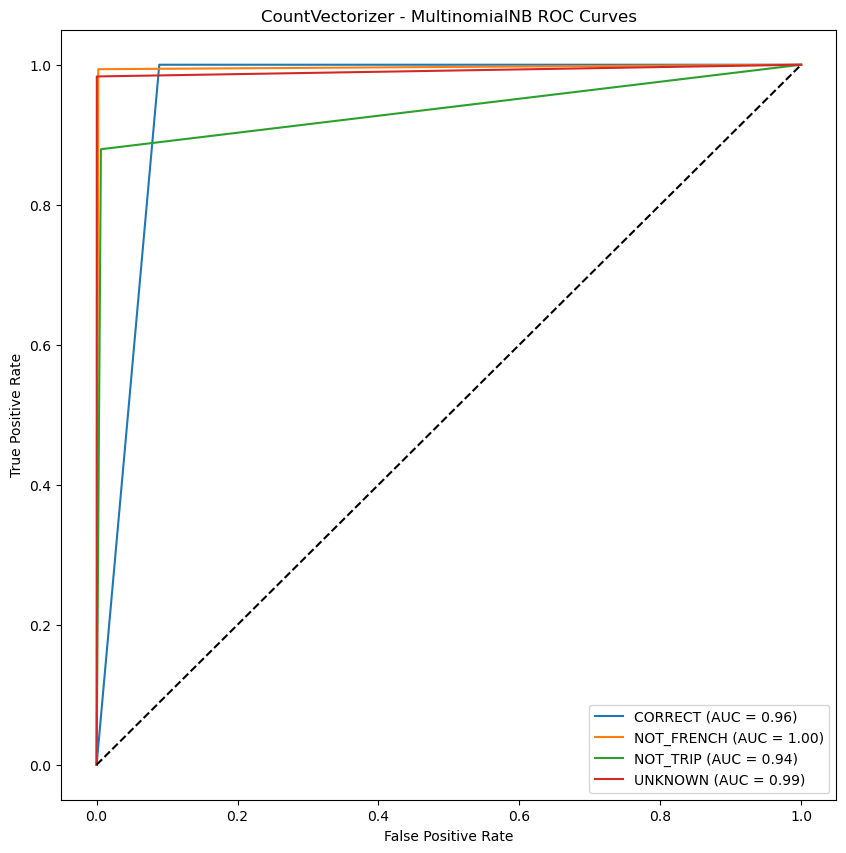

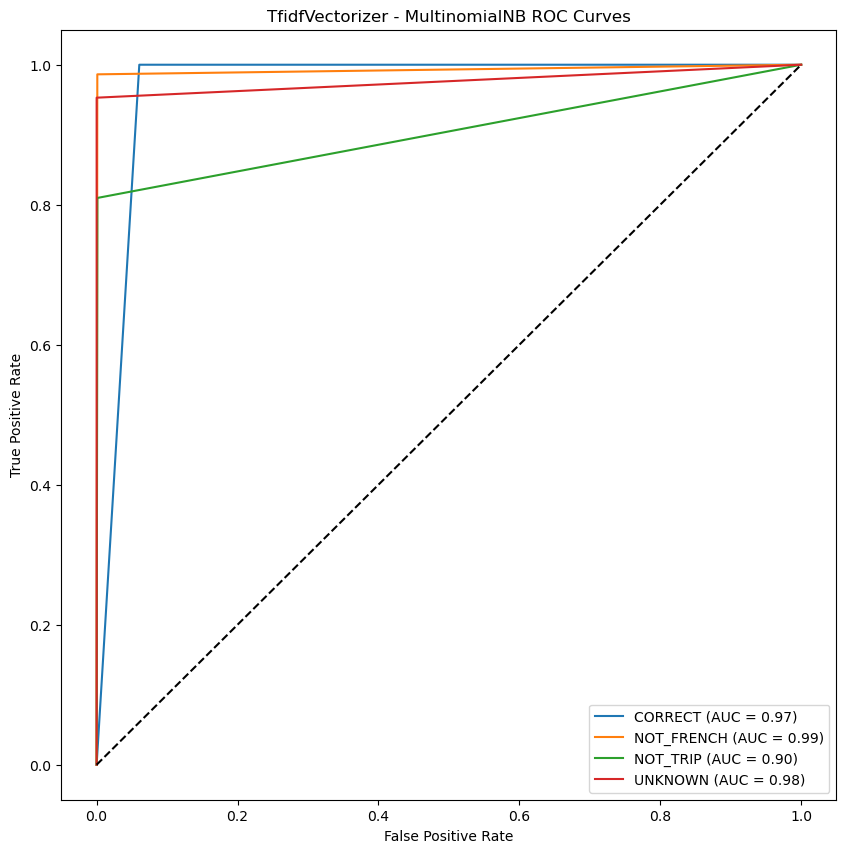

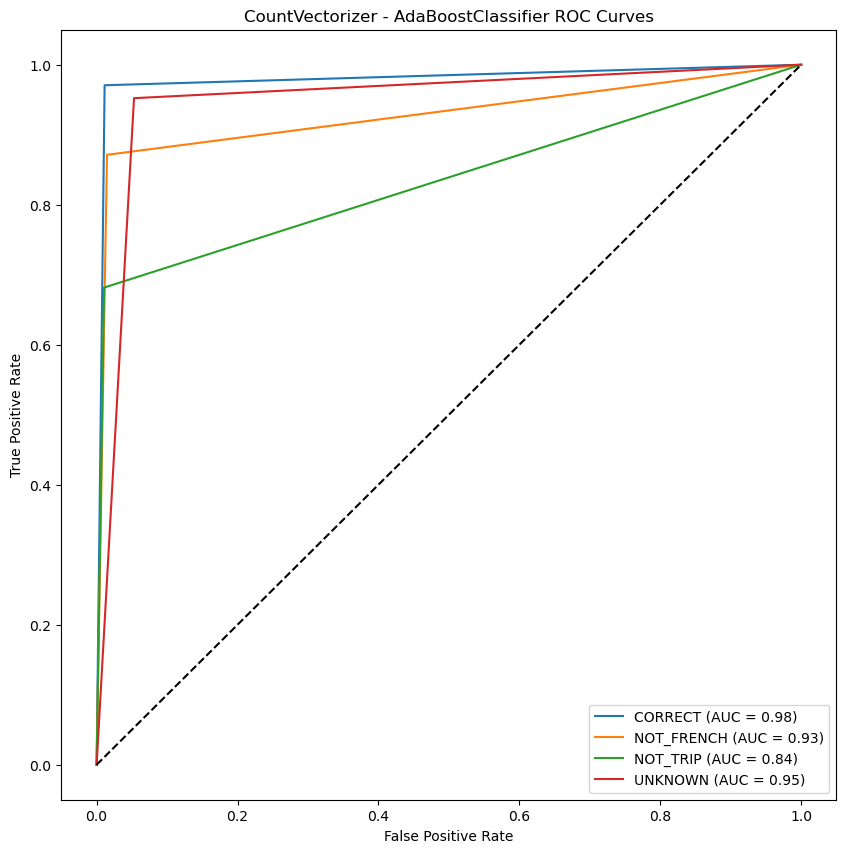

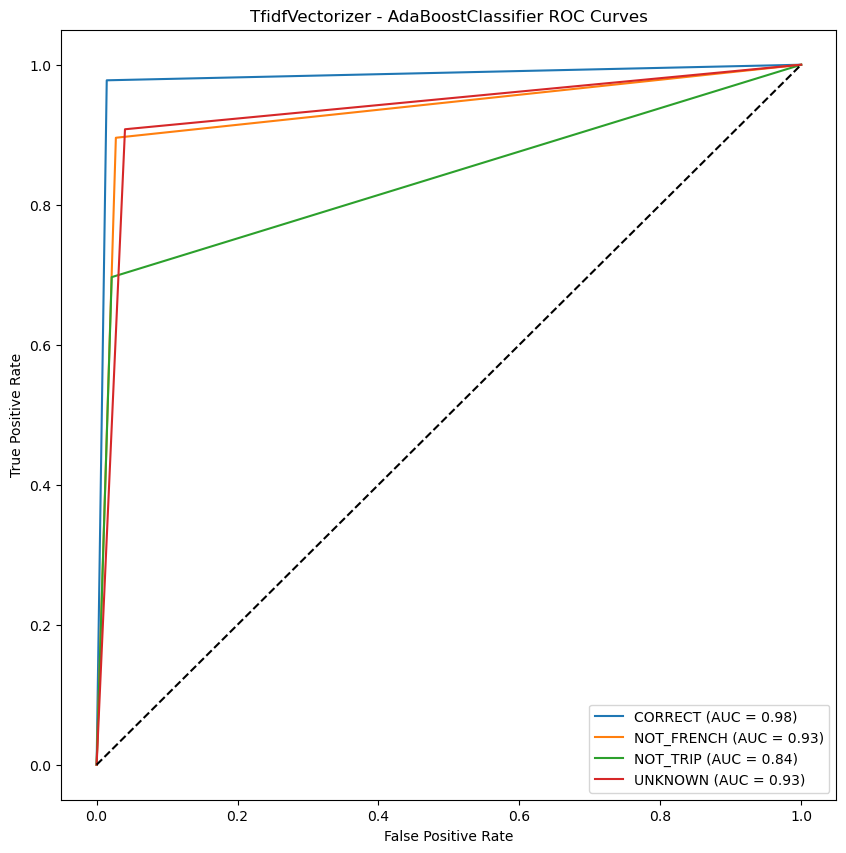

In [10]:
for y_pred, pipeline_label in y_pred_array:
    show_roc_curves(labels, y_pred, y_test, pipeline_label)

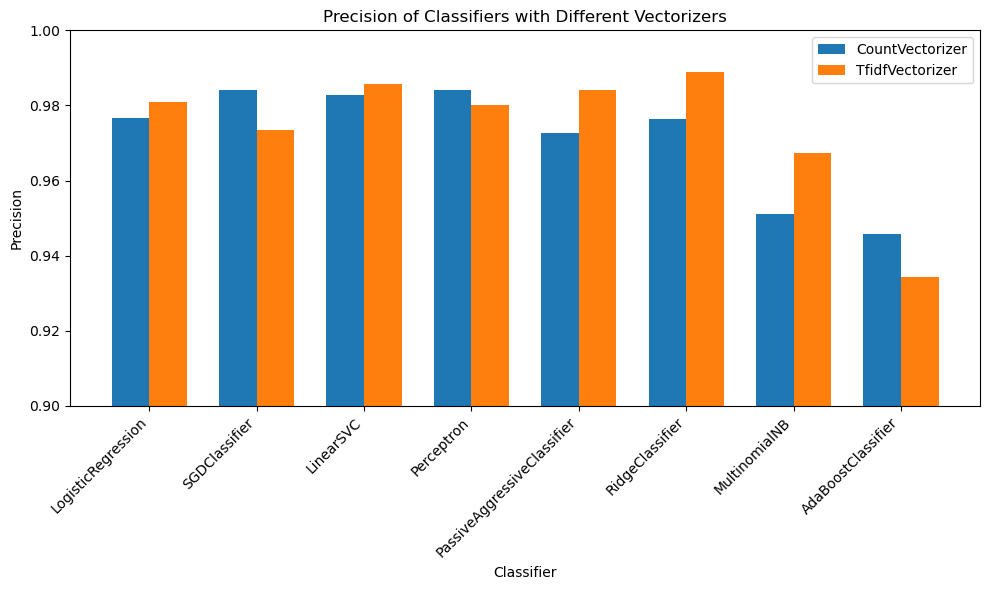

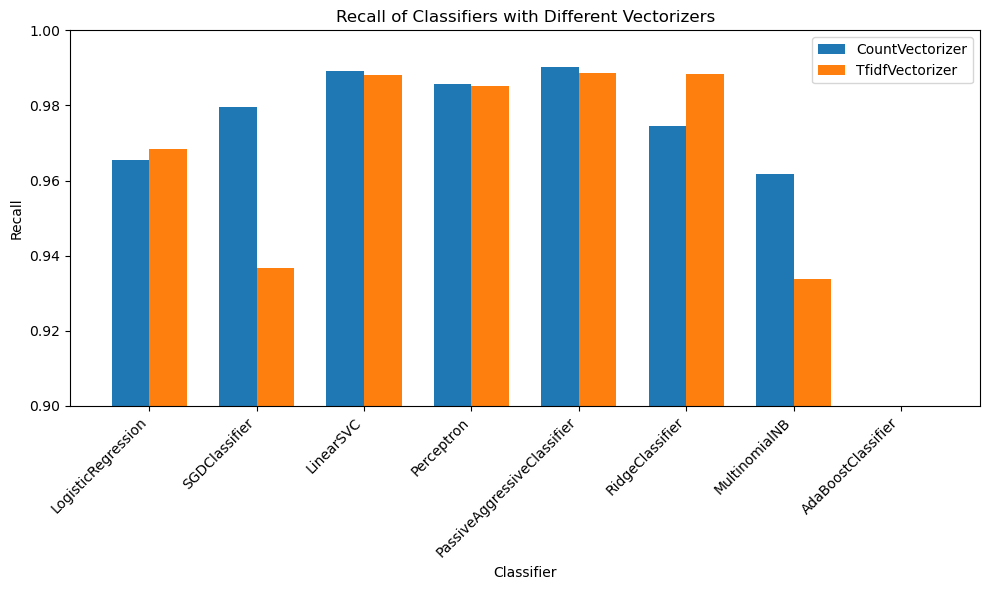

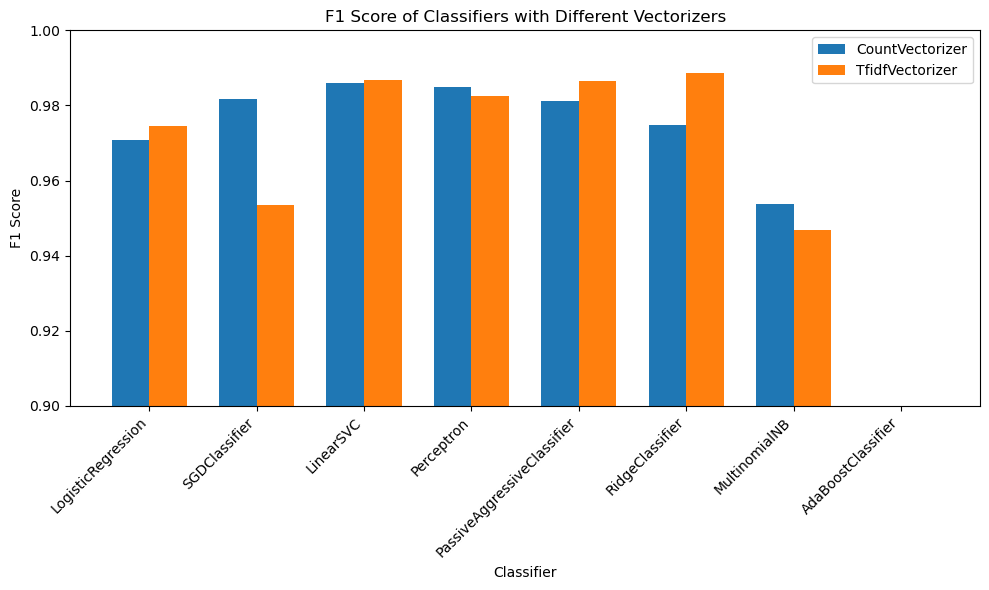

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Calcul des métriques
metrics = {'Precision': [], 'Recall': [], 'F1 Score': []}
for y_pred, pipeline_label in y_pred_array:
    metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Préparation des données pour le graphique en barres
bar_width = 0.35
index = np.arange(len(classifiers))

# Création des graphiques
for metric_name, values in metrics.items():
    plt.figure(figsize=(10, 6))

    # Séparation des valeurs par vectoriseur
    values_vectorizer1 = values[0::2]  # Valeurs pour le premier vectoriseur
    values_vectorizer2 = values[1::2]  # Valeurs pour le deuxième vectoriseur

    # Création des barres
    bars1 = plt.bar(index, values_vectorizer1, bar_width, label='CountVectorizer')
    bars2 = plt.bar(index + bar_width, values_vectorizer2, bar_width, label='TfidfVectorizer')

    # Ajout d'étiquettes et de titres
    plt.xlabel('Classifier')
    plt.ylabel(metric_name)
    plt.ylim(0.9,1)
    plt.title(f'{metric_name} of Classifiers with Different Vectorizers')
    plt.xticks(index + bar_width / 2, [classifier.__class__.__name__ for classifier in classifiers], rotation=45, ha="right")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Certains classifieurs arrivent à obtenir des résultats assez similaire peu importe le vectoriseur utilisé, comme le LinearSVC, le Perceptron, ou le PassiveAggressiveClassifier.

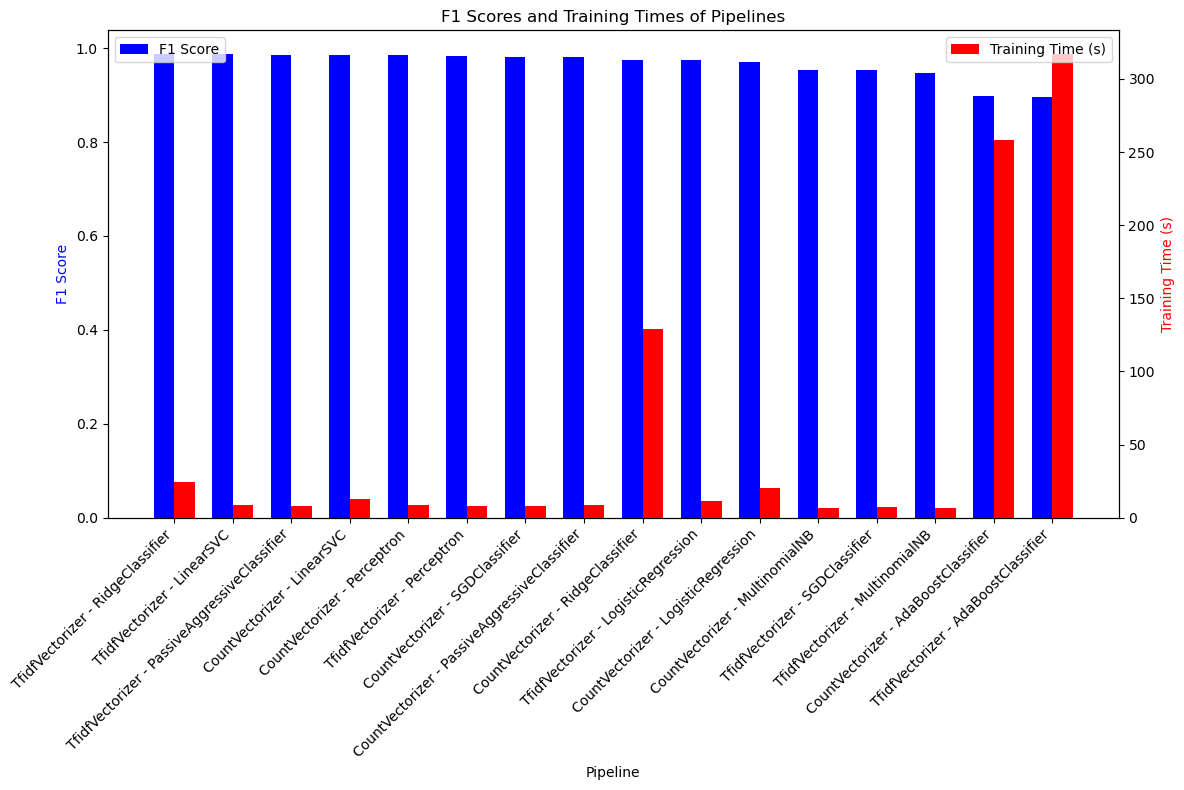

In [12]:
f1_scores = [f1_score(y_test, y_pred, average='weighted') for y_pred, _ in y_pred_array]

# Association des scores F1 et des temps d'entraînement avec leurs labels
scores_and_times = list(zip(f1_scores, training_time_array, [label for _, label in pipelines_array]))

# Tri des tuples par score F1
scores_and_times.sort(reverse=True, key=lambda x: x[0])

# Séparation des données
sorted_f1_scores = [item[0] for item in scores_and_times]
sorted_training_times = [item[1][0] for item in scores_and_times]  # item[1][0] car training_time_array contient des tuples (temps, label)
sorted_labels = [item[2] for item in scores_and_times]

# Création du graphique
index = np.arange(len(sorted_labels))
bar_width = 0.35

plt.figure(figsize=(12, 8))

# Créer un axe pour les F1 scores
ax1 = plt.gca()
ax2 = ax1.twinx()

# Barres pour les F1 scores
ax1.bar(index, sorted_f1_scores, bar_width, label='F1 Score', color='b')

# Barres pour les temps d'entraînement
ax2.bar(index + bar_width, sorted_training_times, bar_width, label='Training Time (s)', color='r')

# Étiquettes et légendes
ax1.set_xlabel('Pipeline')
ax1.set_ylabel('F1 Score', color='b')
ax2.set_ylabel('Training Time (s)', color='r')

# Titres et ticks
plt.title('F1 Scores and Training Times of Pipelines')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(sorted_labels, rotation=45, ha="right")

# Légendes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### On peut observer des f1 scores assez homogènes entre les différents classifieurs et vectoriseurs, excepté pour l'AdaBoostClassifier qui est beaucoup moins performant que les autres.
### En revanche, les temps d'enraînement sont très hétérogènes, avec des différences de plusieurs ordres de grandeur, qui vont permettre d'en faire une métrique de choix pour la décision finale de la combinaison retenue.

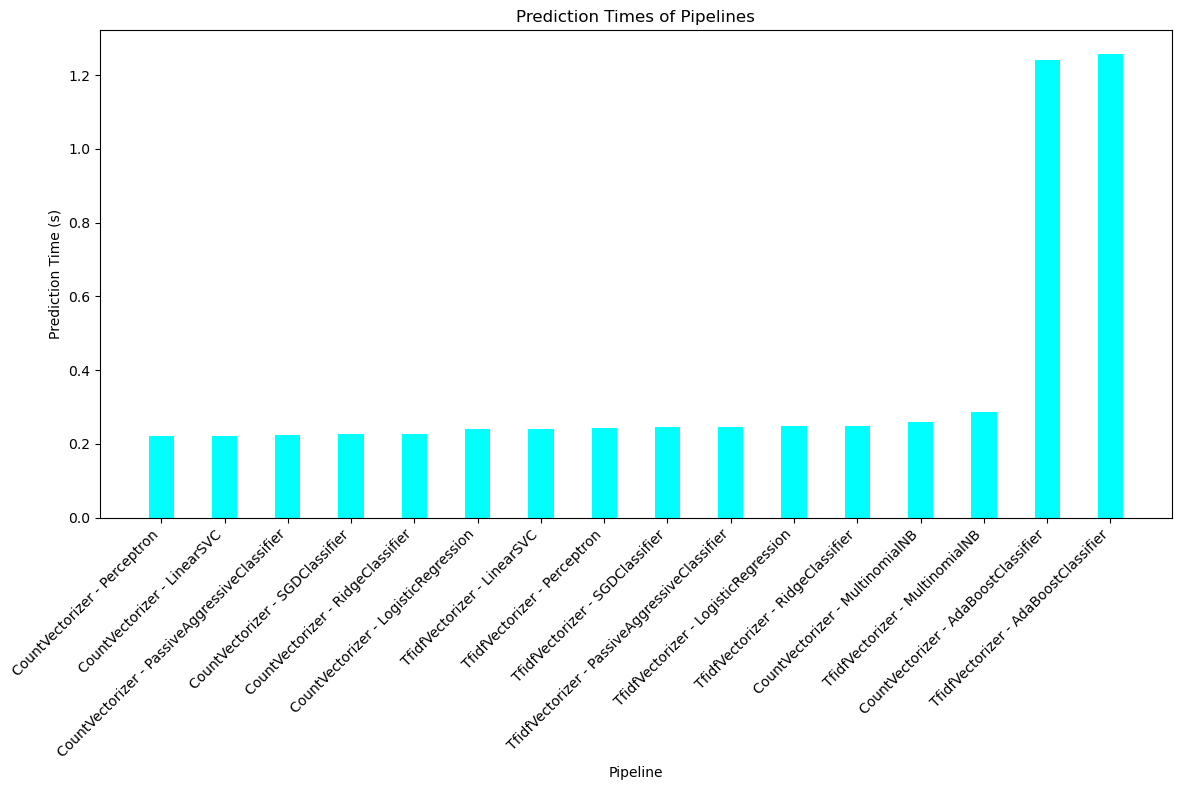

In [13]:
# Ajout des temps de prédiction
prediction_time_array = []

# Réaliser les prédictions sur un sous-ensemble de X_test pour mesurer les temps de prédiction
X_test_subset = X_test[:10000]

for pipeline, label in pipelines_array:
    start_time = time.time()
    y_pred = pipeline.predict(X_test_subset)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_time_array.append((prediction_time, label))

# Tri des pipelines par temps de prédiction
prediction_time_array.sort(key=lambda x: x[0])

# Extraction des données triées pour le graphique
sorted_prediction_times = [item[0] for item in prediction_time_array]
sorted_labels = [item[1] for item in prediction_time_array]

# Création du graphique en barres pour les temps de prédiction
index = np.arange(len(sorted_labels))
bar_width = 0.4

plt.figure(figsize=(12, 8))
plt.bar(index, sorted_prediction_times, bar_width, color='cyan')

plt.xlabel('Pipeline') 
plt.ylabel('Prediction Time (s)')
plt.title('Prediction Times of Pipelines')
plt.xticks(index, sorted_labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Le temps de prédiction est très homogène entre les différents classifieurs et vectoriseurs, excepté pour l'AdaBoostClassifier qui est beaucoup plus lent que les autres.
### On peut tout de même remarquer que le CountVectorizer est légèrement plus rapide que le TfidfVectorizer, en moyenne.

## Après cette analyse, nous pouvons conclure que la meilleure combinaison semble être le TfidfVectorizer et le classificateur LinearSVC.